# MAG Recommendation

In [57]:
import snap
import subprocess
import requests
import json
import time
from IPython.display import Image
from collections import defaultdict
import operator
import datetime

## Create BFS Subgraph
Retrieve the graph produced by a BFS from the given start paper.

In [1]:
from bfs_graph import translate, create_snap_graph, get_bfs_graph

In [45]:
G, mag_to_snap = get_bfs_graph(2366141641, 2, True, False)
snap_to_mag = {v: k for k, v in mag_to_snap.iteritems()}

Starting from 2366141641 and searcher for 2 levels (follow out: true, follow in: false)

Found 1395 nodes, 1684 edges and output edge list to 2366141641.txt


In [ ]:
# Sanity check for correct nodes and ID translation.
for node in G.Nodes():
    print node.GetId(), "\t", snap_to_mag[node.GetId()]

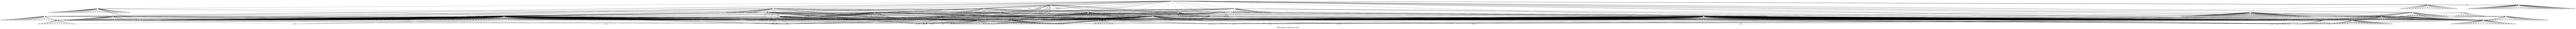

In [17]:
snap.DrawGViz(G, snap.gvlDot, "2366141641.png", "BFS Graph for 2366141641 (Out)")
Image(filename='2366141641.png')

In [73]:
Graph, mag_to_snap_full = get_bfs_graph(633000, 3, True, True)
snap_to_mag_full = {v: k for k, v in mag_to_snap_full.iteritems()}

Starting from 633000 and searcher for 3 levels (follow out: true, follow in: true)

Found 6443 nodes, 7053 edges and output edge list to 633000.txt


In [ ]:
# Sanity check
start_node = Graph.GetNI(633000)
print("633000 has {} references in full BFS graph".format(start_node.GetOutDeg()))
print("633000 has {} citations in full BFS graph".format(start_node.GetInDeg()))

## MAG Request

In [63]:
def mag_evaluate(query, wait_time=10):
    try:
        response = requests.get(
            url="http://api.labs.cognitive.microsoft.com/academic/v1.0/evaluate",
            params={
                "expr": query,
                "model": "latest",
                "count": "10",
                "offset": "0",
                #"orderby": "null",
                "attributes": "Id,Ti,Y,CC,RId,D",
            },
            headers={
                "Ocp-Apim-Subscription-Key": "1c99573804ad445dac00b28fdbafbea3",
                "subscription-key": "",
            },
        )
        
        if response.status_code == 429:
            # print("Rate limited: waiting {} seconds".format(wait_time))
            time.sleep(wait_time)
            return mag_evaluate(query, wait_time/2)
        wait_time = 1
        
       # print('Response HTTP Status Code: {status_code}'.format(
       #     status_code=response.status_code))
        
        resp = json.loads(response.content)
        if 'entities' in resp:
            for obj in resp['entities']:
                obj.pop('E', None)
            return resp['entities']
        else:
            return resp
    except requests.exceptions.RequestException:
        print('HTTP Request failed')
        return None

def mag_get_title(mag_id):
    obj = mag_evaluate("Id={}".format(mag_id))[0]
    return str(obj['Ti']) + " (" + str(int(obj['Y'])) + ")"


format_str = '%Y-%m-%d' # The format
def mag_get_date(mag_id):
    obj = mag_evaluate("Id={}".format(mag_id))[0]
    return datetime.datetime.strptime(obj['D'], format_str)

In [64]:
mag_get_title(2366141641)

'node2vec scalable feature learning for networks (2016)'

## Search Path Count

In [6]:
def get_in_degrees(Graph):
    InDegV = snap.TIntPrV()
    snap.GetNodeInDegV(Graph, InDegV)
    return {item.GetVal1() : item.GetVal2() for item in InDegV}

def get_out_degrees(Graph):
    OutDegV = snap.TIntPrV()
    snap.GetNodeOutDegV(Graph, OutDegV)
    return {item.GetVal1() : item.GetVal2() for item in OutDegV}

In [31]:
def compute_n_minus(start, in_degrees, Graph):
    n_minus = defaultdict(int)
    in_deg = in_degrees.copy()
    while len(start) > 0:
        node = start.pop()
        # print "looking at node", node
        if in_degrees[node] == 0:
            n_minus[node] = 1
        else:
            total = 0
            for citation in Graph.GetNI(node).GetInEdges():
                total += n_minus[citation]
            n_minus[node] = total

        for ref in Graph.GetNI(node).GetOutEdges():
            in_deg[ref] -= 1
            if in_deg[ref] == 0:
                start.add(ref)
                # print "... added", ref
            # else:
                #print "... skipping", ref, "still has ", in_deg[ref], " in edges"
                #print "......", list(Graph.GetNI(ref).GetInEdges())
    return n_minus

In [32]:
def compute_n_plus(start, out_degrees, Graph):
    n_plus = defaultdict(int)
    out_deg = out_degrees.copy()
    while len(start) > 0:
        node = start.pop()
        if out_degrees[node] == 0:
            n_plus[node] = 1
        else:
            total = 0
            for reference in Graph.GetNI(node).GetOutEdges():
                total += n_plus[reference]
            n_plus[node] = total

        for citation in Graph.GetNI(node).GetInEdges():
            out_deg[citation] -= 1
            if out_deg[citation] == 0:
                start.add(citation)
    return n_plus

In [9]:
def spc(Graph):
    in_degrees = get_in_degrees(Graph)
    out_degrees = get_out_degrees(Graph)
    
    n_minus = compute_n_minus(set([node for node in in_degrees if in_degrees[node] == 0]), in_degrees, Graph)
    n_plus = compute_n_plus(set([node for node in out_degrees if out_degrees[node] == 0]), out_degrees, Graph)
    
    spc_counts = defaultdict(int)
    for edge in Graph.Edges():
        src = edge.GetSrcNId()
        dst = edge.GetDstNId()
        spc_counts[(src, dst)] = n_minus[src] * n_plus[dst]
    return spc_counts

## Main Path Analysis

In [25]:
def mpa(start_node, translate, Graph):
    spc_counts = spc(Graph)
    node = start_node
    print mag_get_title(translate[node])
    while Graph.GetNI(node).GetOutDeg() != 0:
        next_node = -1
        largest_spc = -1
        for neighbor in Graph.GetNI(node).GetOutEdges():
            if spc_counts[(node, neighbor)] > largest_spc:
                largest_spc = spc_counts[(node, neighbor)]
                next_node = neighbor
        node = next_node
        print "-", largest_spc, "->", mag_get_title(translate[node])

## Get Foundations Function (Final)

In [74]:
def validate_graph(Graph, snap_to_mag):
    bad_edges = set()
    for edge in Graph.Edges():
        src_nid = edge.GetSrcNId()
        dst_nid = edge.GetDstNId()
        if Graph.IsEdge(dst_nid, src_nid):
            first = min(src_nid, dst_nid)
            second = max(src_nid, dst_nid)
            bad_edges.add((first, second))
    for bad_edge in bad_edges:
        date1 = mag_get_date(snap_to_mag[bad_edge[0]])
        date2 = mag_get_date(snap_to_mag[bad_edge[1]])
        if date1 < date2:
            print "Deleting edge (%d, %d)" % (snap_to_mag[bad_edge[1]], snap_to_mag[bad_edge[0]])
            Graph.DelEdge(bad_edge[1], bad_edge[0])
        else:
            print "Deleting edge (%d, %d)" % (snap_to_mag[bad_edge[0]], snap_to_mag[bad_edge[1]])
            Graph.DelEdge(bad_edge[0], bad_edge[1])

In [80]:
def get_foundations(paper, levels=2, follow_out=True, follow_in=False):
    Graph, mag_to_snap = get_bfs_graph(paper, levels, follow_out, follow_in)
    snap_to_mag = {v: k for k, v in mag_to_snap.iteritems()}
    validate_graph(Graph, snap_to_mag)
    print '='*10
    print "RESULTS:"
    mpa(mag_to_snap[paper], snap_to_mag, Graph)

In [12]:
get_foundations(633000, 3, True, True)

Starting from 633000 and searcher for 3 levels (follow out: true, follow in: true)

Found 6443 nodes, 7053 edges and output edge list to 633000.txt
RESULTS:
coil winder automatically sequencing multiple preset winding selections (1971)
- 442 -> coil winding mechanism (1958)
- 468 -> winding control mechanism (1951)
- 488 -> method of and means for making coils possessing accurate inductance (1933)


In [26]:
get_foundations(2366141641, 2, True, False)

Starting from 2366141641 and searcher for 2 levels (follow out: true, follow in: false)

Found 1395 nodes, 1684 edges and output edge list to 2366141641.txt
RESULTS:
node2vec scalable feature learning for networks (2016)
- 2230 -> grarep learning graph representations with global structural information (2015)
- 1010 -> line large scale information network embedding (2015)
- 1336 -> deepwalk online learning of social representations (2014)
- 1710 -> representation learning a review and new perspectives (2013)
- 198 -> a global geometric framework for nonlinear dimensionality reduction (2000)
- 23 -> independent component analysis a new concept (1994)


In [81]:
get_foundations(2139694940, 2, True, False)

Starting from 2139694940 and searcher for 2 levels (follow out: true, follow in: false)

Found 1536 nodes, 2205 edges and output edge list to 2139694940.txt
Deleting edge (2726858191, 2146591355)
Deleting edge (2050239729, 2068015060)
Deleting edge (2127048411, 2146591355)
Deleting edge (2022704179, 2139694940)
RESULTS:
overlapping community detection at scale a nonnegative matrix factorization approach (2013)
- 21542 -> community affiliation graph model for overlapping network community detection (2012)
- 0 -> uncovering the overlapping community structure of complex networks in nature and society (2005)
- 0 -> defining and identifying communities in networks (2004)
